In [1]:
#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
#MNIST data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [44]:
#local functions
from data.load_data import load_mnist_data
from data.my_dataset import MyDataset
#Classifiers
from src.models import Digit_Classifier
from src.models import Dog_Classifier_FC
from src.models import Dog_Classifier_Conv
#plotting
import matplotlib.pyplot as plt

## Training on MNIST

In [3]:
#load in data
training_sizes = [500, 1000, 1500, 2000]
#for size in training_sizes:
size = 500
tr_f, te_f, tr_t, te_t = load_mnist_data(10, 1, size/10)
    

In [32]:
params = {'batch_size': 500,
          'shuffle': True,
          'num_workers': 0}


In [33]:
trainingset = MyDataset(tr_f, tr_t)
training_generator = DataLoader(trainingset, **params)

#useless bc testing set empty
testingset = MyDataset(te_f, te_t)
testing_generator = DataLoader(testingset, **params)

In [6]:
# len(training_generator) = 50 mini batches of 10

In [35]:
testingset = MyDataset(te_f, te_t)

In [36]:
len(testingset)

1000

In [7]:
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = torch.device("cpu")

In [8]:
def train(epoch, trainloader, idx, optimizer, model, criterion):
    for local_batch, local_labels in trainloader:
        #optionally send to gpu/cpu
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        #stupid line
        local_batch = local_batch.float(); local_labels = local_labels.long()

        #X = local_batch (10,784), Y = batch labels (10,)
        
        #zero grads
        optimizer.zero_grad()
        
        #forward, backward, optimize
        y_hat = model(local_batch)
        loss = criterion(y_hat, local_labels)
        
        #record loss
        losses[idx, epoch] = loss
        
        loss.backward()
        optimizer.step()
    
#assertion errors / warnings? when workers > 0

In [9]:
def test(idx, testloader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.float(); labels = labels.long()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the 1000 test images: %d %%' % (100 * correct / total))
    
    return (100 * correct / total)

In [10]:
#returns a time
def run_epochs(idx, dataloader_obj, opt, model, cri):
    start = time.time()
    for epoch in range(100):
        train(epoch, dataloader_obj, idx, opt, model, cri)
    end = time.time()
    
    return end-start

In [11]:
# hoppers
losses = np.empty((4, 100))
training_sizes = [500, 1000, 1500, 2000]
models = [None]*4
time_elapsed = [None]*4 #in seconds
accuracies = [None]*4 #in percentage

In [12]:
def train_on_mnist():
    for idx, size in enumerate(training_sizes):
        #load in training data
        tr_f, _, tr_t, _ = load_mnist_data(10, 1, size/10)
        
        #make DataLoaders for training
        trainingset = MyDataset(tr_f, tr_t)
        training_generator = DataLoader(trainingset, **params)
        
        #init our classifier, loss, and optimizer
        models[idx] = Digit_Classifier()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(models[idx].parameters(), lr=0.01)
        
        #run 100 epoch loop & record time
        time_elapsed[idx] = run_epochs(idx, training_generator, optimizer, models[idx], criterion)
        
        #evaluate accuracy on testing set
        accuracies[idx] = test(idx, testing_generator, models[idx])

In [37]:
#testing set + DataLoader
_, te_f, _, te_t = load_mnist_data(10, 0, 100)
testingset = MyDataset(te_f, te_t)
testing_generator = DataLoader(testingset, 1000)

In [38]:
train_on_mnist()

Accuracy of the network on the 1000 test images: 14 %
Accuracy of the network on the 1000 test images: 28 %
Accuracy of the network on the 1000 test images: 46 %
Accuracy of the network on the 1000 test images: 48 %


In [39]:
time_elapsed

[0.41965556144714355,
 0.8396413326263428,
 1.4331097602844238,
 1.6884040832519531]

### 1-1

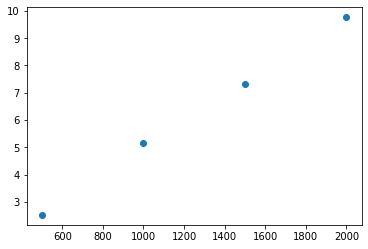

In [16]:
plt.scatter(training_sizes, time_elapsed)

### 1-2
Training time increases linearly with the number of training examples. To train the full MNIST training set of 60K images, it would take (60K/2K)*10seconds/60min/hr = 5hrs

### 1-3

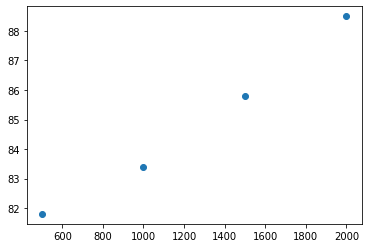

In [17]:
plt.scatter(training_sizes, accuracies)

### 1-4
The training accuracy pretty much also increases linearly wrt number of training examples. Though This would mean that very soon the model will have a very high accuracy and probably this is overfitting.

## Exploring DogSet

In [18]:
from data.dogs import DogsDataset

### 5
7665 in train, 555 in test, 2000 in valid partition, 3 color channels, and 10 dog breeds. 

In [22]:
todogs = DogsDataset('data/DogSet')

loading train...
loading valid...
loading test...


In [29]:
todogs.get_validation_examples()[0].shape

(2000, 64, 64, 3)

In [46]:
l = [1,2,3,4]

In [47]:
try:
    l[-1]
except IndexError as e:
    print("lol")

In [42]:
l[-2]

3

In [71]:
l = []

In [56]:
l == []

True

In [72]:
for i in range(5):
    if i < 2:
        print(i)
        print('hehe')
        pass
    elif l[-1] > l[-2]:
        print(i)
        break
    l.append(i)

0
hehe
1
hehe
2


## Convolutional layers

### 10

In [3]:
in_channels = 3
out_channels = 16
kernel_size = (5,5)
stride = (1, 1)
conv2d1 = nn.Conv2d(in_channels, out_channels, 
                   kernel_size, stride=stride, 
                  )

In [6]:
inputs = torch.Tensor(0.1 * np.ones((1,64,64,3)))
inputs.shape

torch.Size([1, 64, 64, 3])

In [7]:
out = conv2d1(inputs)

RuntimeError: Given groups=1, weight of size [16, 3, 5, 5], expected input[1, 64, 64, 3] to have 3 channels, but got 64 channels instead

In [169]:
out.shape

torch.Size([16, 16, 28, 28])

In [170]:
inputs = F.max_pool2d(F.relu(conv2d1(inputs)), 2)

In [171]:
inputs.shape

torch.Size([16, 16, 14, 14])

In [172]:
in_channels = 16
out_channels = 32
kernel_size = (5, 5)
stride = (1, 1)
conv2d2 = nn.Conv2d(in_channels, out_channels, 
                   kernel_size, stride=stride, 
                  )

In [173]:
inputs = F.max_pool2d(F.relu(conv2d2(inputs)), 2)

In [174]:
inputs.shape

torch.Size([16, 32, 5, 5])

In [177]:
fc3 = nn.Linear(5, 10)

In [178]:
inputs = fc3(inputs)

In [179]:
inputs.shape

torch.Size([16, 32, 5, 10])

In [31]:
ins = torch.rand(3,64,64).view(-1, 3, 64, 64)
ins.shape

torch.Size([1, 3, 64, 64])

In [32]:
c1 = nn.Conv2d(3, 16, 5, 1)

In [33]:
c2 = nn.Conv2d(16, 32, 5, 1)

In [34]:
ins = F.max_pool2d(F.relu(c1(ins)), 2)
ins.shape

torch.Size([1, 16, 30, 30])

In [35]:
ins = F.max_pool2d(F.relu(c2(ins)), 2)
ins.shape

torch.Size([1, 32, 13, 13])

In [36]:
fc3 = nn.Linear(13, 10)

In [37]:
ins = fc3(ins)
ins.shape

torch.Size([1, 32, 13, 10])

Input to conv2d:
(batchsize, channels, height, width)
Output:
(batchsize, channels_out, height_out, width_out) for outs based on documentation math

In [38]:
a = torch.rand(1,2,3,4)
print(a.transpose(0,3).transpose(1,2).size())
print(a.permute(3,2,1,0).size())

torch.Size([4, 3, 2, 1])
torch.Size([4, 3, 2, 1])


In [43]:
a.shape
a = torch.transpose(a, 2, 3).shape
a.shape

torch.Size([1, 2, 3, 4])